# Hyperparameter Tuning of a Deep MLP on the MNIST Dataset Using Keras Tuner

## Load Dataset

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## Preprocessing

In [3]:
#scale the data to [0,1]
x_train, x_test = x_train / 255.0, x_test / 255.0

from tensorflow.keras.utils import to_categorical
#one-hot encode the labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

## Train MLP on the dataset

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

In [5]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(256, activation='relu'),
    Dropout(0.2), 
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
    ])

C:\Users\bademari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
history = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8177 - loss: 0.6115 - val_accuracy: 0.9569 - val_loss: 0.1439
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9539 - loss: 0.1509 - val_accuracy: 0.9680 - val_loss: 0.1069
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9694 - loss: 0.1019 - val_accuracy: 0.9712 - val_loss: 0.0964
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9750 - loss: 0.0771 - val_accuracy: 0.9753 - val_loss: 0.0808
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9802 - loss: 0.0628 - val_accuracy: 0.9753 - val_loss: 0.0839
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9828 - loss: 0.0534 - val_accuracy: 0.9772 - val_loss: 0.0760
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9856 - loss: 0.0461 - val_accuracy: 0.9779 - val_loss: 0.0777
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9866 - loss: 0.0430 - val_accuracy: 0.

## Evaluate on the test set

In [8]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")
#Output: Test accuracy: 0.9811

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.9773 - loss: 0.1052
Test accuracy: 0.9811


## Hyperparametertuning using Keras

In [22]:
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.4, step=0.1)))

    model.add(Dense(10, activation='softmax'))

    
    learning_rate = hp.Float('learning_rate', min_value=1e-3, max_value=1e-1, sampling='log')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [24]:
import keras_tuner as kt
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='output',
    project_name='mnist_tuning_v3'
)

C:\Users\bademari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
tuner.search(x_train, y_train,
             epochs=10,
             validation_split=0.2,
             batch_size=tuner.oracle.hyperparameters.Int('batch_size', min_value=32, max_value=128, step=32))

Trial 20 Complete [00h 01m 42s]
val_accuracy: 0.9594166576862335

Best val_accuracy So Far: 0.9801666736602783
Total elapsed time: 00h 25m 08s


In [26]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f" - Number of layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f" - Units in layer {i}: {best_hps.get(f'units_{i}')}")
    print(f" - Dropout Rate in layer {i}: {best_hps.get(f'dropout_{i}')}")
print(f" - Learning Rate: {best_hps.get('learning_rate')}")
print(f" - Batch Size: {best_hps.get('batch_size')}")

Best Hyperparameters:
 - Number of layers: 1
 - Units in layer 0: 448
 - Dropout Rate in layer 0: 0.30000000000000004
 - Learning Rate: 0.001323743940619104
 - Batch Size: 32


## Train best model

In [28]:
best_model = tuner.hypermodel.build(best_hps)

In [29]:
import time
start_time = time.time()
history = best_model.fit(
    x_train, y_train,
    epochs=20, 
    batch_size=best_hps.get('batch_size'),
    validation_split=0.2
)
training_time = time.time() - start_time

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8829 - loss: 0.3933 - val_accuracy: 0.9645 - val_loss: 0.1187
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9614 - loss: 0.1235 - val_accuracy: 0.9685 - val_loss: 0.1017
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9720 - loss: 0.0873 - val_accuracy: 0.9726 - val_loss: 0.0886
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9790 - loss: 0.0675 - val_accuracy: 0.9778 - val_loss: 0.0792
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9820 - loss: 0.0536 - val_accuracy: 0.9767 - val_loss: 0.0809
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9827 - loss: 0.0529 - val_accuracy: 0.9764 - val_loss: 0.0880
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9851 - loss: 0.0443 - val_accuracy: 0.9795 - val_loss: 0.0807
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9866 - loss: 0.0389 - 

In [30]:
print(f"Training time: {training_time:.2f} seconds")

Training time: 56.54 seconds


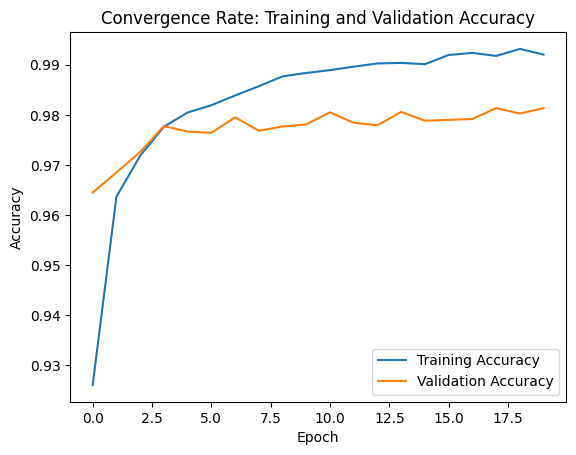

In [31]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Convergence Rate: Training and Validation Accuracy')
plt.legend()
plt.show()

## Evaluate on the test set

In [32]:
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.9782 - loss: 0.1276
Test Accuracy: 0.9824


### Confusion Matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step


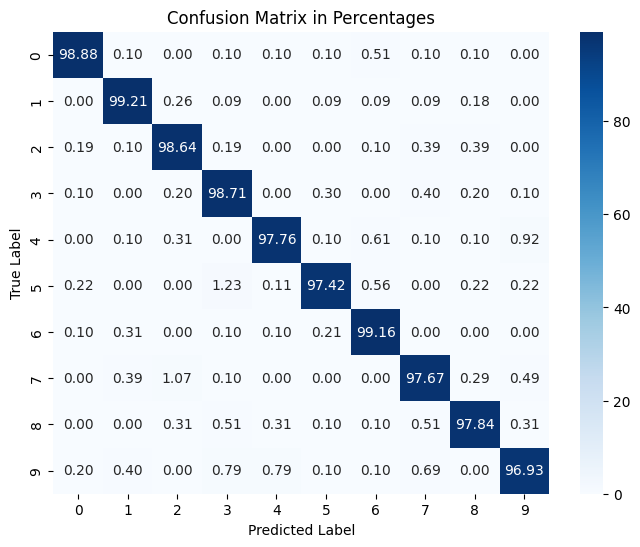

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = best_model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_test.argmax(axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix in Percentages')
plt.show()

### F-Score, Precision & Recall

In [39]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_true_classes, y_pred_classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()

In [40]:
precision = report_df.loc[report_df.index.str.isdigit(), 'precision']
recall = report_df.loc[report_df.index.str.isdigit(), 'recall']
f1_score = report_df.loc[report_df.index.str.isdigit(), 'f1-score']
classes = range(10)

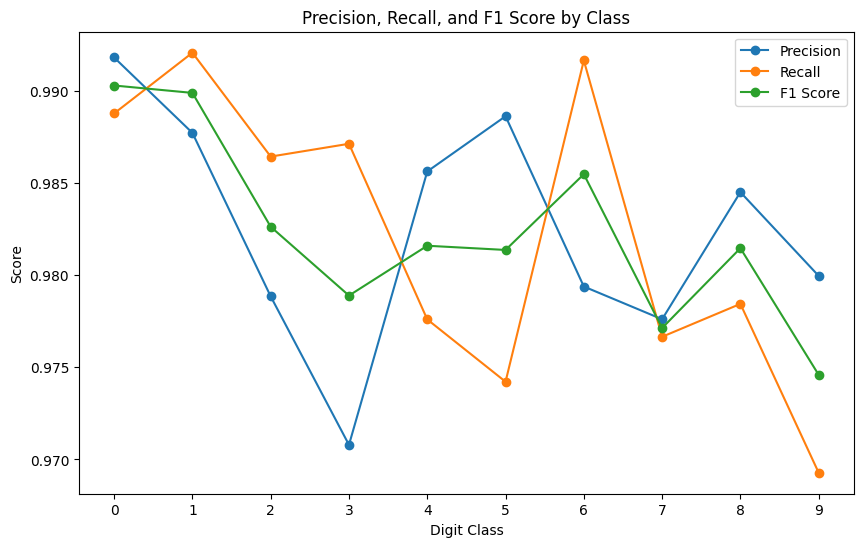

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(classes, precision, marker='o', label='Precision')
plt.plot(classes, recall, marker='o', label='Recall')
plt.plot(classes, f1_score, marker='o', label='F-1 Score')
plt.xlabel('Digit Class')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score by Class')
plt.xticks(classes)
plt.legend()
plt.show()